In [ ]:
!pip install -U -t /kaggle/working/ git+https://github.com/Kaggle/learntools.git@embeddings-v2

In [ ]:
!pip install -U -t /kaggle/working/ gensim

In [ ]:
import sys
sys.path.append('/kaggle/working')

# Exercise (Gensim / vector math)

In this exercise, you'll get to do some of your exploration of our trained movie embeddings, using some of the Gensim tools I showed in [the tutorial](https://www.kaggle.com/colinmorris/3-exploring-embeddings-with-gensim). To get started, run the setup cell below to import the libraries we'll be using, load our raw embedding data, and wrap it in a `WordEmbeddingsKeyedVectors` object.

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

from learntools.core import binder; binder.bind(globals())
from learntools.embeddings.ex3_gensim import *

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input/0-movielens-preprocessing' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
model_dir = '../input/x3-movielens-spiffy-model' if RUNNING_ON_KERNELS else '.'
model_path = os.path.join(model_dir, 'movie_svd_model_32.h5')
model = keras.models.load_model(model_path)

emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()
movie_embedding_size = w.shape[1]

movies_path = os.path.join(input_dir, 'movie.csv')
all_movies_df = pd.read_csv(movies_path, index_col=0)

threshold = 100

movies = all_movies_df[all_movies_df.n_ratings >= threshold].reset_index(drop=True)

kv = WordEmbeddingsKeyedVectors(movie_embedding_size)
kv.add(
    movies['key'].values,
    w[movies.movieId]
)

## 1. Warm-up

As a warm-up, try using the `kv.most_similar` method on a few of your favourite movies. What do you think of the results? Are there any that stick out as being a bad match? Any movies that you think *should* be on the list but which aren't? 

In [ ]:
# Example: one of my favourite films by Alfred Hitchcock. Try with some of your favourite movies.
kv.most_similar('Vertigo')

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Strangers on a Train', 0.9427046775817871),
 ('Rear Window', 0.9409477710723877),
 ('North by Northwest', 0.9366045594215393),
 ('Sunset Blvd. (a.k.a. Sunset Boulevard)', 0.9357169270515442),
 ('The Third Man', 0.9308935403823853),
 ('Maltese Falcon, The (a.k.a. Dangerous Female)', 0.9279078245162964),
 ('The Treasure of the Sierra Madre', 0.9239088296890259),
 ('The Maltese Falcon', 0.9194389581680298),
 ('Paths of Glory', 0.9179232120513916),
 ('Notorious (1946)', 0.9070533514022827)]

In [ ]:
# Note: if you get a KeyError when looking up a movie, you may want to run something like this
# to look up the 'key' column for your movie. For example, there's more than one movie with the 
# title 'Spellbound', so I need to either call:
#     kv.most_similar('Spellbound (1945)')
# If I want the Hitchcock thriller, or:
#     kv.most_similar('Spellbound (2002)')
# If I want the documentary on spelling bees.
movies[movies.title.str.contains('Spellbound')]

,movieId,title,genres,key,year,n_ratings,mean_rating
789,914,Spellbound,Mystery|Romance|Thriller,Spellbound (1945),1945,2268,3.920195
4851,6232,Spellbound,Documentary,Spellbound (2002),2002,2888,3.987314


If you find any particularly interesting or funny examples, feel free to share them on [the forums](TODO).

## 2. *Bambi* + *The Mummy* = ???

So far we've seen the `most_similar()` method called in the following ways:
- with a single (positive) example `m1`, giving us the movies most similar to `m1`
- with one positive example, `m1`, and one negative example, `m2`. The results seem to roughly correspond to the question "which movies exemplify the properties that `m1` has and `m2` doesn't?"
- with two positive examples, `m1` and `m2`, and one negative example, `m3`, which answers the analogy "`m3` is to `m2` as `m1` is to ____".

What do you think will happen (mathematically, and semantically) if we call it with two positive examples, and no negative examples? 

In the code cell below, try calling `most_similar()` with *Legally Blonde* and *Mission: Impossible* as two positive examples. If you're familiar with the movies, see if you can predict what kinds of movies will be returned.

In [ ]:
# TODO: call most_similar with the movies "Legally Blonde" and "Mission: Impossible" as positive examples,
# and assign the results to the variable legally_impossible
legally_impossible = None
print(legally_impossible)
part2.check()

None


<IPython.core.display.Javascript object>

<span style="color:#cc3333">Incorrect:</span> Expected legally_impossible to have type `<class 'list'>` but had type `<class 'NoneType'>`

Try experimenting with adding other pairs of movies. Do you see a pattern emerging?

What do you think happens if we pass in the same movie twice?

In [ ]:
# Feel free to continue experimenting here.

Uncomment the line below to see an explanation of what's going on.

In [ ]:
#part2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
legally_impossible = kv.most_similar(positive=['Legally Blonde', 'Mission: Impossible'])
```

Passing in two positive examples, `m1` and `m2`, finds the vectors that are most similar to `m1 + m2`. Semantically, this corresponds to movies that are about halfway between `m1` and `m2` in terms of meaning. 

In light of this interpretation, some of our `legally_impossible` results make a lot of sense. *Miss Congeniality*, *Mr. & Mrs. Smith*, and *Charlie's Angels* are all examples of movies that combine the "chick flick comedy" properties of *Legally Blonde* with the action/spy movie properties of *Mission: Impossible*.

What happens if we run something like `kv.most_similar(positive=['Legally Blonde', 'Legally Blonde'])`? We get the exact same results as `kv.most_similar('Legally Blonde')`. The reason comes down to our use of cosine distance. If we add a movie vector `m1` to itself, we get a vector that's twice as long, but its *angle* remains the same. So for any pair of movies `m1`, `m2`, `distance.cosine(m1, m2) == distance.cosine(m1+m1, m2)`.


**Bonus**: Pick a movie you like (let's call it `m`), and see if you can find two other movies, `m1` and `m2` such that `m1 + m2 ≈ m`. Of course you're pretty likely to succeed if you choose two movies which are each similar to `m`, but can you come up with a pair of very *different* movies that have `m` right between them? Again, if you're successful here, feel free to share on [the forums](TODO).

## 3. Cosine distance vs. Euclidean distance

If you're familiar with linear algebra, you may know that the cosine distance and euclidean distance of two vectors are equivalent (up to a scaling factor) if those vectors have the same length. In particular, when our vectors both have length 1, their euclidean distance is just twice their cosine distance.

Given that we cared about using cosine distance rather than Euclidean distance, we must have some reason to believe that our embedding vectors vary in length. But how much? And is there any pattern to which movies' vectors are long or short?

### 3a. Distribution of lengths

Just as there are lots of definitions of distance, there are lots of definitions of length. But we'll be using the familiar notion, technically called the 'Euclidean norm' or 'L2 norm'. What's the length of the vector `(3, 4)`? Well, if we start at `(0, 0)`, walk 3 steps to the right, and then 4 steps up, we'll get a right triangle where the hypotenuse connects `(3, 4)` to `(0, 0)`. By the Pythagorean theorem, the length of that hypotenuse is $\sqrt{3^2 + 4^2} = \sqrt{25} = 5$. We can extend the calculation to any number of dimensions - for example, the L2 norm of the vector `(1, 1, 3, 5)` is $\sqrt{1^2 + 1^2 + 3^2 + 5^2} = 6$.

Fortunately, we don't need to implement the calculations ourselves. Given a vector, the function [`numpy.linalg.norm`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) returns its L2 norm. Run the cell below to calculate the L2 norm of our model's first movie embedding vector:

In [ ]:
np.linalg.norm(w[0])

2.0208979

Fill in the missing code in the cell below to create a variable `norms`, containing the L2 norms of all the model's movie embeddings.

In [ ]:
norms = None
part3.a.check()

<IPython.core.display.Javascript object>

<span style="color:#cc3333">Incorrect:</span> Expected norms to have type `<class 'numpy.ndarray'>` but had type `<class 'NoneType'>`

In [ ]:
#part3.a.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Check out the axis keyword of np.linalg.norm in numpy's documentation: [https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)

In [ ]:
#part3.a.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
norms = np.linalg.norm(w, axis=1)
```

Once you've successfully calculated `norms`, run the following cell to generate a visualization of the distribution of lengths of our movie embedding vectors.

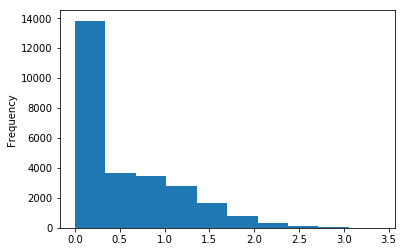

In [ ]:
norm_series = pd.Series(norms)
norm_series.plot.hist();

### 3b. Patterns in vector lengths?

Fill in the missing code below to add a column called `norm` containing the length of each movie's embedding to our DataFrame containing all movies (`all_movies_df`).

In [ ]:
# TODO: Your code goes here. Add the column "norm" to our movies dataframe.
part3.b.check()

<IPython.core.display.Javascript object>

<span style="color:#cc3333">Incorrect:</span> Expected dataframe `all_movies_df` to have column norm

In [ ]:
#part3.b.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
all_movies_df['norm'] = norms
```

Run the cells below to see the movies with the largest and smallest embedding vectors. Do you see a pattern?

In [ ]:
n = 5
# Movies with the smallest embeddings (as measured by L2 norm)
all_movies_df.sort_values(by='norm').head(n)

,movieId,title,genres,key,year,n_ratings,mean_rating,norm
24994,24994,Carry On Teacher,Comedy,Carry On Teacher,1959,1,3.5,0.0
20020,20020,Consuming Spirits,Animation|Comedy|Drama|Mystery,Consuming Spirits,2012,1,NaN,0.0
24549,24549,Dream Boy,Drama|Romance,Dream Boy,2008,1,3.5,0.0
24543,24543,Demoted,Comedy,Demoted,2011,1,3.5,0.0
24539,24539,Love Sick Love,Thriller,Love Sick Love,2013,1,NaN,0.0


In [ ]:
# Movies with the largest embeddings
all_movies_df.sort_values(by='norm', ascending=False).head(n)

,movieId,title,genres,key,year,n_ratings,mean_rating,norm
6373,6373,From Justin to Kelly,Musical|Romance,From Justin to Kelly,2003,426,0.983831,3.396398
228,228,Dumb & Dumber (Dumb and Dumber),Adventure|Comedy,Dumb & Dumber (Dumb and Dumber),1994,32085,2.950768,3.321958
4679,4679,Glitter,Drama|Musical|Romance,Glitter,2001,685,1.121705,3.313496
6477,6477,Gigli,Comedy|Crime|Romance,Gigli,2003,701,1.168390,3.258397
9754,9754,Son of the Mask,Adventure|Children|Comedy|Fantasy,Son of the Mask,2005,467,1.254525,3.245531


Uncomment the cell below for some speculation about what's going on.

In [ ]:
#part3.c.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> TODO

`</exercise>`

# Scratch space

## Look up your favourite movie and judge how legit the similar titles are! 

## multiple positive movies

What movies do you get if you combine x + y? What movies lie between x and y?

## cos distance vs. euclidean

looking at different magnitudes of movies

-----------------

## analogies? Not sure if better to do in an exercise, or in the body of lesson. Or both.

## clustering...?

## exploring more gensim methods

`doesnt_match`, 

## Exploring individual dimensions of the embedding space

In [ ]:
all_movies_df[all_movies_df.n_ratings >= threshold].sort_values(by='norm').head(n)

,movieId,title,genres,key,year,n_ratings,mean_rating,norm
19246,19246,The Angels' Share,Comedy|Drama,The Angels' Share,2012,105,3.676768,0.314971
19299,19299,The Queen of Versailles,Documentary,The Queen of Versailles,2012,144,3.640288,0.359256
17047,17047,Mildred Pierce,Drama,Mildred Pierce (2011),2011,120,3.712389,0.379933
9044,9044,Diggstown,Drama,Diggstown,1992,107,3.426471,0.381574
19341,19341,Celeste and Jesse Forever (Celeste & Jesse For...,Comedy|Drama|Romance,Celeste and Jesse Forever (Celeste & Jesse For...,2012,109,3.364078,0.403814
